In [ ]:
! pip install pennylane scikit-learn pandas

In [ ]:
import time
import pennylane as qml
from pennylane.kernels import kernel_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------
# 📊 DATA LOADING & PREPROCESSING
# ------------------------
files = [
    "/content/Autism-Child-Data.csv",
    "/content/Autism-Adolescent-Data.csv",
    "/content/Autism-Adult-Data.csv"
]

df_list = [pd.read_csv(f) for f in files]
df = pd.concat(df_list, ignore_index=True)
df = df.dropna().drop_duplicates()

target_col = 'Class/ASD'
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
if target_col in cat_cols:
    cat_cols.remove(target_col)
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Binary target
df[target_col] = df[target_col].map({'NO': 0, 'YES': 1})

# Shuffle & sample
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df_small = df.iloc[:100]

X = df_small.drop(target_col, axis=1).values
y = df_small[target_col].values
print(f"Sampled dataset shape: {X.shape}")

# Normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# ------------------------
# ⚛️ QUANTUM SVM: QSVM
# ------------------------
n_qubits = X.shape[1]
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def kernel_circuit(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.probs(wires=range(n_qubits))

def quantum_kernel(x1, x2):
    return kernel_circuit(x1, x2)[0]

# Compute kernel matrices with timing
print("Computing quantum kernel matrices...")
start = time.time()
K_train = kernel_matrix(X_train, X_train, kernel=quantum_kernel)
K_test  = kernel_matrix(X_test,  X_train, kernel=quantum_kernel)
print(f"Kernel computation took {time.time()-start:.2f}s")

# Train SVM on quantum kernel
clf = SVC(kernel='precomputed')
clf.fit(K_train, y_train)

y_train_pred = clf.predict(K_train)
y_test_pred  = clf.predict(K_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc  = accuracy_score(y_test,  y_test_pred)

# ------------------------
# RESULTS & REPORT
# ------------------------
print(f"\n--- QSVM Results ---")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:     {test_acc:.4f}\n")
print(classification_report(y_test, y_test_pred))

# ------------------------
# 📈 ACCURACY BAR PLOT
# ------------------------
plt.figure()
plt.bar(['Train', 'Test'], [train_acc, test_acc])
plt.title('QSVM Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()


Sampled dataset shape: (100, 20)
Computing quantum kernel matrices...


KeyboardInterrupt: 

In [ ]:
# VQC => version 1

import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

# ------------------------
# 📊 DATA LOADING & PREPROCESSING
# ------------------------
files = [
    "/content/Autism-Child-Data.csv",
    "/content/Autism-Adolescent-Data.csv",
    "/content/Autism-Adult-Data.csv"
]

# Load and concatenate
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

df = df.dropna().drop_duplicates()

# Identify and encode all object-type (categorical) columns, except the target
target_col = 'Class/ASD'
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
if target_col in cat_cols:
    cat_cols.remove(target_col)

for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Map target to binary
df[target_col] = df[target_col].map({'NO': 0, 'YES': 1})

# Shuffle and sample
df = shuffle(df, random_state=42).reset_index(drop=True)
df_small = df.iloc[:200]

# Separate features and target
y = df_small[target_col].values
X = df_small.drop(target_col, axis=1).values

print(f"Sampled dataset shape: {X.shape}")

# Normalize
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Split sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Convert to torch
torch.manual_seed(42)
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float()
X_test_t  = torch.from_numpy(X_test).float()
y_test_t  = torch.from_numpy(y_test).float()

# ------------------------
# ⚛️ QUANTUM CIRCUIT SETUP
# ------------------------
n_qubits = 2
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch", diff_method="backprop")
def circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs[:n_qubits], wires=list(range(n_qubits)))
    qml.templates.StronglyEntanglingLayers(weights, wires=list(range(n_qubits)))
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

weight_shapes = {"weights": (n_layers, n_qubits, 3)}
qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)

class VQCModel(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.pre_net  = nn.Linear(in_features, n_qubits)
        self.q_net    = qlayer
        self.post_net = nn.Sequential(nn.Linear(n_qubits, 1), nn.Sigmoid())

    def forward(self, x):
        # x: [batch, features]
        x = self.pre_net(x)           # [batch, n_qubits]
        # apply quantum layer per sample
        q_outs = torch.stack([self.q_net(x[i]) for i in range(x.shape[0])], dim=0)
        # q_outs: [batch, n_qubits]
        out = self.post_net(q_outs)   # [batch, 1]
        return out.view(-1)           # [batch]

# Instantiate model, optimizer, loss
dim_in = X_train.shape[1]
model     = VQCModel(dim_in)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn   = nn.BCELoss()

# ------------------------
# 🚀 TRAINING
# ------------------------
epochs = 25
for epoch in range(1, epochs+1):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss    = loss_fn(outputs, y_train_t)
    loss.backward()
    optimizer.step()

    preds = (outputs.detach().cpu().numpy() > 0.5).astype(int)
    acc   = accuracy_score(y_train, preds)
    print(f"Epoch {epoch:02d} — Loss: {loss.item():.4f} — Acc: {acc:.4f}")

# ------------------------
# 🧪 EVALUATION
# ------------------------
model.eval()
with torch.no_grad():
    test_out   = model(X_test_t)
    test_preds = (test_out.cpu().numpy() > 0.5).astype(int)
    test_acc   = accuracy_score(y_test, test_preds)

print(f"\nTest Accuracy (VQC): {test_acc:.4f}")


Sampled dataset shape: (200, 20)
Epoch 01 — Loss: 0.7809 — Acc: 0.3375
Epoch 02 — Loss: 0.7665 — Acc: 0.3375
Epoch 03 — Loss: 0.7517 — Acc: 0.3500
Epoch 04 — Loss: 0.7368 — Acc: 0.3563
Epoch 05 — Loss: 0.7218 — Acc: 0.3875
Epoch 06 — Loss: 0.7071 — Acc: 0.4313
Epoch 07 — Loss: 0.6926 — Acc: 0.4625
Epoch 08 — Loss: 0.6786 — Acc: 0.5312
Epoch 09 — Loss: 0.6651 — Acc: 0.5687
Epoch 10 — Loss: 0.6519 — Acc: 0.6375
Epoch 11 — Loss: 0.6391 — Acc: 0.6750
Epoch 12 — Loss: 0.6268 — Acc: 0.7250
Epoch 13 — Loss: 0.6149 — Acc: 0.7375
Epoch 14 — Loss: 0.6033 — Acc: 0.7688
Epoch 15 — Loss: 0.5922 — Acc: 0.7875
Epoch 16 — Loss: 0.5815 — Acc: 0.8500
Epoch 17 — Loss: 0.5713 — Acc: 0.8875
Epoch 18 — Loss: 0.5614 — Acc: 0.8875
Epoch 19 — Loss: 0.5519 — Acc: 0.8875
Epoch 20 — Loss: 0.5427 — Acc: 0.8875
Epoch 21 — Loss: 0.5339 — Acc: 0.8875
Epoch 22 — Loss: 0.5253 — Acc: 0.8875
Epoch 23 — Loss: 0.5170 — Acc: 0.8875
Epoch 24 — Loss: 0.5087 — Acc: 0.8938
Epoch 25 — Loss: 0.5005 — Acc: 0.9000

Test Accuracy (V

Sampled dataset shape: (200, 20)
Epoch 01 — Loss: 0.7809 — Acc: 0.3375 — LR: 0.01000
Epoch 02 — Loss: 0.7665 — Acc: 0.3375 — LR: 0.01000
Epoch 03 — Loss: 0.7517 — Acc: 0.3500 — LR: 0.01000
Epoch 04 — Loss: 0.7368 — Acc: 0.3563 — LR: 0.01000
Epoch 05 — Loss: 0.7218 — Acc: 0.3875 — LR: 0.01000
Epoch 06 — Loss: 0.7071 — Acc: 0.4313 — LR: 0.01000
Epoch 07 — Loss: 0.6926 — Acc: 0.4625 — LR: 0.01000
Epoch 08 — Loss: 0.6786 — Acc: 0.5312 — LR: 0.01000
Epoch 09 — Loss: 0.6651 — Acc: 0.5687 — LR: 0.01000
Epoch 10 — Loss: 0.6519 — Acc: 0.6375 — LR: 0.01000
Epoch 11 — Loss: 0.6391 — Acc: 0.6750 — LR: 0.01000
Epoch 12 — Loss: 0.6268 — Acc: 0.7250 — LR: 0.01000
Epoch 13 — Loss: 0.6149 — Acc: 0.7375 — LR: 0.01000
Epoch 14 — Loss: 0.6033 — Acc: 0.7688 — LR: 0.01000
Epoch 15 — Loss: 0.5922 — Acc: 0.7875 — LR: 0.01000
Epoch 16 — Loss: 0.5815 — Acc: 0.8500 — LR: 0.01000
Epoch 17 — Loss: 0.5713 — Acc: 0.8875 — LR: 0.01000
Epoch 18 — Loss: 0.5614 — Acc: 0.8875 — LR: 0.01000
Epoch 19 — Loss: 0.5519 — Acc: 

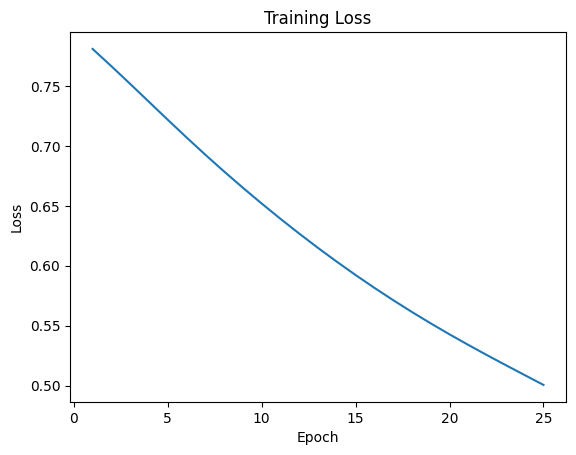

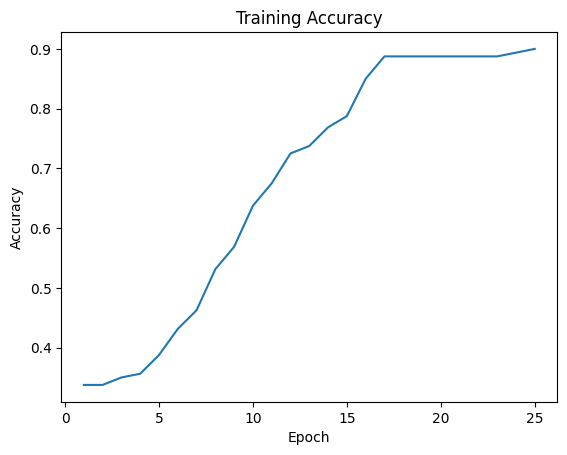

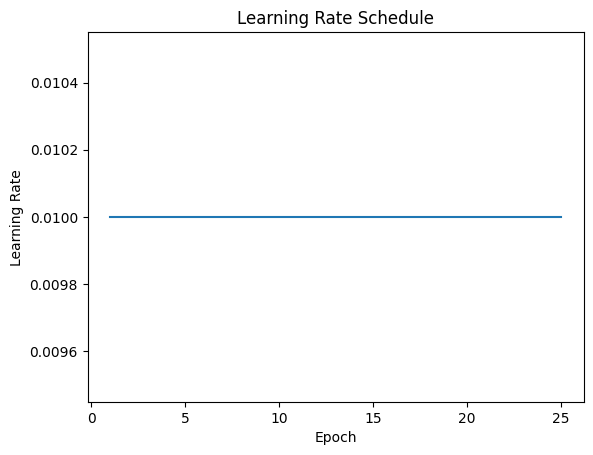


Test Accuracy (VQC): 1.0000


In [ ]:
# VCQ => version-2 (with basic graphs)

import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# ------------------------
# 📊 DATA LOADING & PREPROCESSING
# ------------------------
files = [
    "/content/Autism-Child-Data.csv",
    "/content/Autism-Adolescent-Data.csv",
    "/content/Autism-Adult-Data.csv"
]

df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df = df.dropna().drop_duplicates()

target_col = 'Class/ASD'
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
if target_col in cat_cols:
    cat_cols.remove(target_col)
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

df[target_col] = df[target_col].map({'NO': 0, 'YES': 1})
df = shuffle(df, random_state=42).reset_index(drop=True)
df_small = df.iloc[:200]

y = df_small[target_col].values
X = df_small.drop(target_col, axis=1).values
print(f"Sampled dataset shape: {X.shape}")

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

torch.manual_seed(42)
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float()
X_test_t  = torch.from_numpy(X_test).float()
y_test_t  = torch.from_numpy(y_test).float()

# ------------------------
# ⚛️ QUANTUM CIRCUIT SETUP
# ------------------------
n_qubits = 2
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch", diff_method="backprop")
def circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs[:n_qubits], wires=list(range(n_qubits)))
    qml.templates.StronglyEntanglingLayers(weights, wires=list(range(n_qubits)))
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

weight_shapes = {"weights": (n_layers, n_qubits, 3)}
qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)

class VQCModel(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.pre_net  = nn.Linear(in_features, n_qubits)
        self.q_net    = qlayer
        self.post_net = nn.Sequential(nn.Linear(n_qubits, 1), nn.Sigmoid())

    def forward(self, x):
        x = self.pre_net(x)
        q_outs = torch.stack([self.q_net(x[i]) for i in range(x.shape[0])], dim=0)
        out = self.post_net(q_outs)
        return out.view(-1)

# Instantiate model, optimizer, loss
dim_in = X_train.shape[1]
model     = VQCModel(dim_in)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn   = nn.BCELoss()

# ------------------------
# 🚀 TRAINING
# ------------------------
epochs = 25
loss_history = []
acc_history = []
lr_history = []

for epoch in range(1, epochs+1):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss    = loss_fn(outputs, y_train_t)
    loss.backward()
    optimizer.step()

    preds = (outputs.detach().cpu().numpy() > 0.5).astype(int)
    acc   = accuracy_score(y_train, preds)

    # record metrics
    loss_history.append(loss.item())
    acc_history.append(acc)
    lr_history.append(optimizer.param_groups[0]['lr'])

    print(f"Epoch {epoch:02d} — Loss: {loss.item():.4f} — Acc: {acc:.4f} — LR: {lr_history[-1]:.5f}")

# ------------------------
# 📈 PLOTTING METRICS
# ------------------------
# Loss
plt.figure()
plt.plot(range(1, epochs+1), loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Accuracy
plt.figure()
plt.plot(range(1, epochs+1), acc_history)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Learning Rate
plt.figure()
plt.plot(range(1, epochs+1), lr_history)
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

# ------------------------
# 🧪 EVALUATION
# ------------------------
model.eval()
with torch.no_grad():
    test_out   = model(X_test_t)
    test_preds = (test_out.cpu().numpy() > 0.5).astype(int)
    test_acc   = accuracy_score(y_test, test_preds)

print(f"\nTest Accuracy (VQC): {test_acc:.4f}")


Sampled dataset shape: (500, 20)
[QNN] Epoch 01 — Loss: 0.6757 — Acc: 0.6125 — LR: 0.01000
[QNN] Epoch 02 — Loss: 0.6699 — Acc: 0.6125 — LR: 0.01000
[QNN] Epoch 03 — Loss: 0.6638 — Acc: 0.6125 — LR: 0.01000
[QNN] Epoch 04 — Loss: 0.6574 — Acc: 0.6125 — LR: 0.01000
[QNN] Epoch 05 — Loss: 0.6508 — Acc: 0.6125 — LR: 0.01000
[QNN] Epoch 06 — Loss: 0.6439 — Acc: 0.6125 — LR: 0.01000
[QNN] Epoch 07 — Loss: 0.6364 — Acc: 0.6125 — LR: 0.01000
[QNN] Epoch 08 — Loss: 0.6284 — Acc: 0.6125 — LR: 0.01000
[QNN] Epoch 09 — Loss: 0.6198 — Acc: 0.6125 — LR: 0.01000
[QNN] Epoch 10 — Loss: 0.6106 — Acc: 0.6125 — LR: 0.01000
[QNN] Epoch 11 — Loss: 0.6007 — Acc: 0.6125 — LR: 0.01000
[QNN] Epoch 12 — Loss: 0.5903 — Acc: 0.6125 — LR: 0.01000
[QNN] Epoch 13 — Loss: 0.5793 — Acc: 0.6125 — LR: 0.01000
[QNN] Epoch 14 — Loss: 0.5681 — Acc: 0.6125 — LR: 0.01000
[QNN] Epoch 15 — Loss: 0.5567 — Acc: 0.6125 — LR: 0.01000
[QNN] Epoch 16 — Loss: 0.5455 — Acc: 0.6125 — LR: 0.01000
[QNN] Epoch 17 — Loss: 0.5344 — Acc: 0.

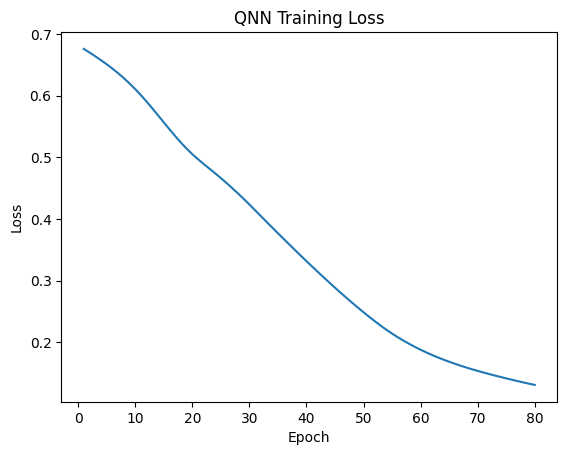

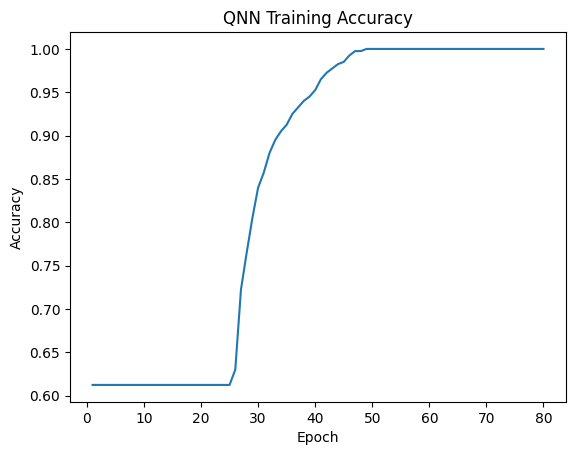

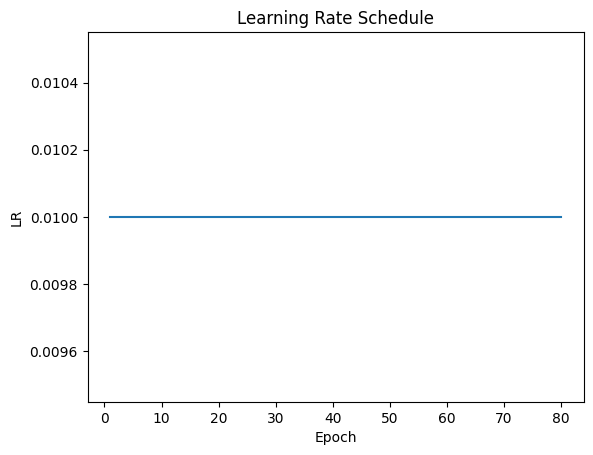


Test Accuracy (QNN): 0.9800


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# ------------------------
# 📊 DATA LOADING & PREPROCESSING
# ------------------------
files = [
    "/content/Autism-Child-Data.csv",
    "/content/Autism-Adolescent-Data.csv",
    "/content/Autism-Adult-Data.csv"
]

df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df = df.dropna().drop_duplicates()

target_col = 'Class/ASD'
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
if target_col in cat_cols:
    cat_cols.remove(target_col)
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

df[target_col] = df[target_col].map({'NO': 0, 'YES': 1})
df = shuffle(df, random_state=42).reset_index(drop=True)
df_small = df.iloc[:500]

y = df_small[target_col].values
X = df_small.drop(target_col, axis=1).values
print(f"Sampled dataset shape: {X.shape}")

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

torch.manual_seed(42)
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float()
X_test_t  = torch.from_numpy(X_test).float()
y_test_t  = torch.from_numpy(y_test).float()

# ------------------------
# ⚛️ QUANTUM CIRCUIT SETUP
# ------------------------
n_qubits = 2
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch", diff_method="backprop")
def circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs[:n_qubits], wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

weight_shapes = {"weights": (n_layers, n_qubits, 3)}
qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)

# ------------------------
# 🧠 HYBRID QNN MODEL
# ------------------------
class QNNModel(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        # classical feature extractor
        self.pre_net = nn.Sequential(
            nn.Linear(in_features, 4),
            nn.ReLU(),
            nn.Linear(4, n_qubits)
        )
        # quantum circuit
        self.q_net = qlayer
        # final classifier
        self.post_net = nn.Sequential(
            nn.Linear(n_qubits, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # classical -> quantum -> classical
        x = self.pre_net(x)  # [batch, n_qubits]
        # apply quantum layer sample-wise
        q_outs = torch.stack([self.q_net(x[i]) for i in range(x.shape[0])], dim=0)
        out = self.post_net(q_outs)  # [batch,1]
        return out.view(-1)        # [batch]

# instantiate QNN
dim_in = X_train.shape[1]
model_qnn = QNNModel(dim_in)
optimizer = optim.Adam(model_qnn.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

epochs = 80
loss_history = []
acc_history = []
lr_history = []

# ------------------------
# 🚀 TRAINING LOOP
# ------------------------
for epoch in range(1, epochs+1):
    model_qnn.train()
    optimizer.zero_grad()
    outputs = model_qnn(X_train_t)
    loss = loss_fn(outputs, y_train_t)
    loss.backward()
    optimizer.step()

    preds = (outputs.detach().cpu().numpy() > 0.5).astype(int)
    acc = accuracy_score(y_train, preds)

    # record metrics
    loss_history.append(loss.item())
    acc_history.append(acc)
    lr_history.append(optimizer.param_groups[0]['lr'])

    print(f"[QNN] Epoch {epoch:02d} — Loss: {loss.item():.4f} — Acc: {acc:.4f} — LR: {lr_history[-1]:.5f}")

# ------------------------
# 📈 PLOTTING METRICS
# ------------------------
plt.figure()
plt.plot(range(1, epochs+1), loss_history)
plt.title('QNN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(range(1, epochs+1), acc_history)
plt.title('QNN Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.figure()
plt.plot(range(1, epochs+1), lr_history)
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.show()

# ------------------------
# 🧪 EVALUATION
# ------------------------
model_qnn.eval()
with torch.no_grad():
    test_outs = model_qnn(X_test_t)
    test_preds = (test_outs.cpu().numpy() > 0.5).astype(int)
    test_acc = accuracy_score(y_test, test_preds)

print(f"\nTest Accuracy (QNN): {test_acc:.4f}")


Sampled dataset shape: (200, 20)
[Reupload] Epoch 01 — Loss: 0.6763 — Acc: 0.6250 — LR: 0.01500
[Reupload] Epoch 02 — Loss: 0.6493 — Acc: 0.6438 — LR: 0.01500
[Reupload] Epoch 03 — Loss: 0.6293 — Acc: 0.6562 — LR: 0.01500
[Reupload] Epoch 04 — Loss: 0.6163 — Acc: 0.6625 — LR: 0.01500
[Reupload] Epoch 05 — Loss: 0.6081 — Acc: 0.6625 — LR: 0.01500
[Reupload] Epoch 06 — Loss: 0.6020 — Acc: 0.6625 — LR: 0.01500
[Reupload] Epoch 07 — Loss: 0.5967 — Acc: 0.6625 — LR: 0.01500
[Reupload] Epoch 08 — Loss: 0.5918 — Acc: 0.6625 — LR: 0.01500
[Reupload] Epoch 09 — Loss: 0.5874 — Acc: 0.6625 — LR: 0.01500
[Reupload] Epoch 10 — Loss: 0.5836 — Acc: 0.6625 — LR: 0.01500
[Reupload] Epoch 11 — Loss: 0.5798 — Acc: 0.6625 — LR: 0.01500
[Reupload] Epoch 12 — Loss: 0.5757 — Acc: 0.6625 — LR: 0.01500
[Reupload] Epoch 13 — Loss: 0.5712 — Acc: 0.6625 — LR: 0.01500
[Reupload] Epoch 14 — Loss: 0.5663 — Acc: 0.6625 — LR: 0.01500
[Reupload] Epoch 15 — Loss: 0.5612 — Acc: 0.6625 — LR: 0.01500
[Reupload] Epoch 16 — 

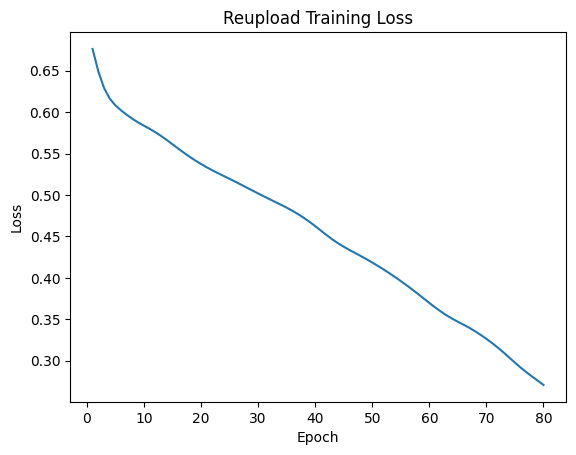

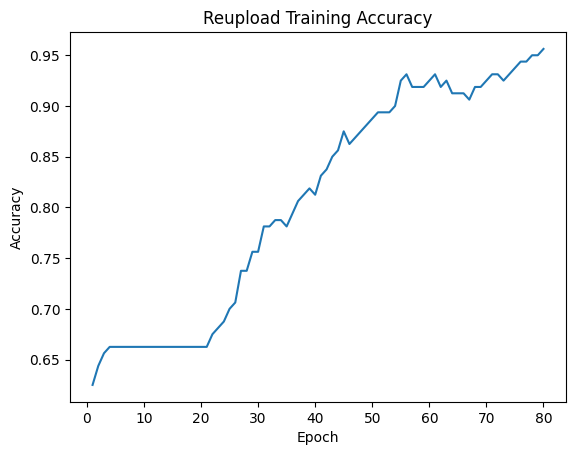

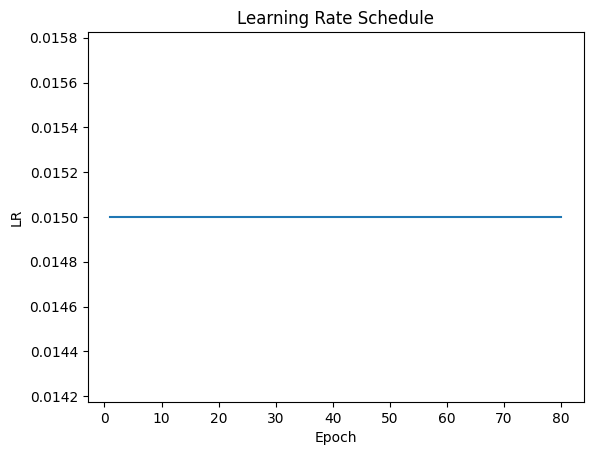


Test Accuracy (Reuploading): 0.8000


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# ------------------------
# 📊 DATA LOADING & PREPROCESSING
# ------------------------
files = [
    "/content/Autism-Child-Data.csv",
    "/content/Autism-Adolescent-Data.csv",
    "/content/Autism-Adult-Data.csv"
]

df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df = df.dropna().drop_duplicates()

# Encode categorical features except target
target_col = 'Class/ASD'
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
if target_col in cat_cols:
    cat_cols.remove(target_col)
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Binary target
df[target_col] = df[target_col].map({'NO': 0, 'YES': 1})
df = shuffle(df, random_state=42).reset_index(drop=True)
df_small = df.iloc[:200]

# Features and labels
X = df_small.drop(target_col, axis=1).values
y = df_small[target_col].values
print(f"Sampled dataset shape: {X.shape}")

# Normalize
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

torch.manual_seed(42)
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float()
X_test_t  = torch.from_numpy(X_test).float()
y_test_t  = torch.from_numpy(y_test).float()

# ------------------------
# ⚛️ QUANTUM CIRCUIT SETUP (Reuploading)
# ------------------------
n_qubits = 2
layers = 4
dev = qml.device("default.qubit", wires=n_qubits)

# Reuploading circuit definition
def reuploading_circuit(inputs, weights):
    for w in range(weights.shape[0]):
        qml.AngleEmbedding(inputs[:n_qubits], wires=range(n_qubits))
        qml.Rot(*weights[w, 0], wires=0)
        qml.Rot(*weights[w, 1], wires=1)
        qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(0))

# QNode and TorchLayer
weight_shapes = {"weights": (layers, n_qubits, 3)}
qnode_reupload = qml.QNode(reuploading_circuit, dev, interface="torch", diff_method="backprop")
qlayer_reupload = qml.qnn.TorchLayer(qnode_reupload, weight_shapes)

# ------------------------
# 🧠 REUPLOAD HYBRID MODEL
# ------------------------
class ReuploadModel(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.pre_net  = nn.Linear(in_features, n_qubits)
        self.q_net    = qlayer_reupload
        self.post_net = nn.Sequential(nn.Linear(1, 1), nn.Sigmoid())

    def forward(self, x):
        # classical to qubit dimension
        x = self.pre_net(x)  # [batch, n_qubits]
        # quantum reuploading per sample, returns scalar per sample
        q_scalars = [self.q_net(x[i]) for i in range(x.shape[0])]
        # shape [batch]
        q_outs = torch.stack(q_scalars, dim=0).unsqueeze(1)  # [batch, 1]
        # post-processing
        out = self.post_net(q_outs)  # [batch, 1]
        return out.view(-1)          # [batch]

# Instantiate model, optimizer, loss
dim_in = X_train.shape[1]
model_reupload = ReuploadModel(dim_in)
optimizer = optim.Adam(model_reupload.parameters(), lr=0.015)
loss_fn = nn.BCELoss()

epochs = 80
loss_history = []
acc_history  = []
lr_history   = []

# ------------------------
# 🚀 TRAINING LOOP
# ------------------------
for epoch in range(1, epochs+1):
    model_reupload.train()
    optimizer.zero_grad()

    outputs = model_reupload(X_train_t)  # [batch]
    loss = loss_fn(outputs, y_train_t)
    loss.backward()
    optimizer.step()

    preds = (outputs.detach().cpu().numpy() > 0.5).astype(int)
    acc = accuracy_score(y_train, preds)

    # Record metrics
    loss_history.append(loss.item())
    acc_history.append(acc)
    lr_history.append(optimizer.param_groups[0]['lr'])

    print(f"[Reupload] Epoch {epoch:02d} — Loss: {loss.item():.4f} — Acc: {acc:.4f} — LR: {lr_history[-1]:.5f}")

# ------------------------
# 📈 PLOTTING METRICS
# ------------------------
plt.figure()
plt.plot(range(1, epochs+1), loss_history)
plt.title('Reupload Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(range(1, epochs+1), acc_history)
plt.title('Reupload Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.figure()
plt.plot(range(1, epochs+1), lr_history)
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.show()

# ------------------------
# 🧪 EVALUATION
# ------------------------
model_reupload.eval()
with torch.no_grad():
    test_outs = model_reupload(X_test_t)
    test_preds = (test_outs.cpu().numpy() > 0.5).astype(int)
    test_acc = accuracy_score(y_test, test_preds)

print(f"\nTest Accuracy (Reuploading): {test_acc:.4f}")
